In [1]:
# -*- coding: utf-8 -*-
"""
Created in 2024

@author: Quant Galore
"""

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from pandas_market_calendars import get_calendar

C:\Users\Austin\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [9]:
polygon_api_key = "KkfCQ7fsZnx0yK4bhX9fD81QplTh0Pf3"
calendar = get_calendar("NYSE")

trading_dates = calendar.schedule(start_date = "2023-05-01", end_date = (datetime.today()-timedelta(days = 1))).index.strftime("%Y-%m-%d").values

ticker = "I:SPX"
index_ticker = "I:VIX1D"
options_ticker = "SPX"
etf_ticker = "SPY"

trade_time = "09:35"
            
move_adjustment = .5
spread_width = 1

trade_list = []
times = []

In [72]:
date = trading_dates[250]
exp_date = date
date

'2024-04-29'

In [73]:
start_time = datetime.now()
        
prior_day = trading_dates[np.where(trading_dates==date)[0][0]-1]

prior_day_underlying_data = pd.json_normalize(requests.get(f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/day/{prior_day}/{prior_day}?adjusted=true&sort=asc&limit=50000&apiKey={polygon_api_key}").json()["results"]).set_index("t")
prior_day_underlying_data.index = pd.to_datetime(prior_day_underlying_data.index, unit="ms", utc=True).tz_convert("America/New_York")

big_underlying_data = pd.json_normalize(requests.get(f"https://api.polygon.io/v2/aggs/ticker/{etf_ticker}/range/1/day/2020-01-01/{prior_day}?adjusted=true&sort=asc&limit=50000&apiKey={polygon_api_key}").json()["results"]).set_index("t")
big_underlying_data.index = pd.to_datetime(big_underlying_data.index, unit="ms", utc=True).tz_convert("America/New_York")

etf_underlying_data = pd.json_normalize(requests.get(f"https://api.polygon.io/v2/aggs/ticker/{etf_ticker}/range/1/minute/{date}/{date}?adjusted=true&sort=asc&limit=50000&apiKey={polygon_api_key}").json()["results"]).set_index("t")
etf_underlying_data.index = pd.to_datetime(etf_underlying_data.index, unit="ms", utc=True).tz_convert("America/New_York")

underlying_data = pd.json_normalize(requests.get(f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/minute/{date}/{date}?adjusted=true&sort=asc&limit=50000&apiKey={polygon_api_key}").json()["results"]).set_index("t")
underlying_data.index = pd.to_datetime(underlying_data.index, unit="ms", utc=True).tz_convert("America/New_York")

index_data = pd.json_normalize(requests.get(f"https://api.polygon.io/v2/aggs/ticker/{index_ticker}/range/1/minute/{date}/{date}?adjusted=true&sort=asc&limit=50000&apiKey={polygon_api_key}").json()["results"]).set_index("t")
index_data.index = pd.to_datetime(index_data.index, unit="ms", utc=True).tz_convert("America/New_York")

In [74]:
etf_underlying_data = etf_underlying_data[etf_underlying_data.index.time >= pd.Timestamp(trade_time).time()].copy()
underlying_data = underlying_data[(underlying_data.index.time >= pd.Timestamp(trade_time).time()) & (underlying_data.index.time <= pd.Timestamp("16:00").time())].copy()
index_data = index_data[index_data.index.time >= pd.Timestamp(trade_time).time()].copy()

prior_day_price = prior_day_underlying_data["c"].iloc[0]
index_price = index_data["c"].iloc[0]        
price = underlying_data["c"].iloc[0]
closing_value = underlying_data["c"].iloc[-1]

overnight_move = round(((price - prior_day_price) / prior_day_price)*100, 2)

expected_move = (round((index_price / np.sqrt(252)), 2)/100)*move_adjustment

lower_price = round(price - (price * expected_move))
upper_price = round(price + (price * expected_move))

overnight_move, expected_move, lower_price, price, upper_price

(0.39, 0.00265, 5106, 5119.77, 5133)

In [75]:
concatenated_regime_dataset = pd.concat([big_underlying_data, etf_underlying_data.head(1)], axis = 0)
concatenated_regime_dataset["1_mo_avg"] = concatenated_regime_dataset["c"].rolling(window=20).mean()
concatenated_regime_dataset["3_mo_avg"] = concatenated_regime_dataset["c"].rolling(window=60).mean()
concatenated_regime_dataset['regime'] = concatenated_regime_dataset.apply(lambda row: 1 if (row['c'] > row['1_mo_avg']) else 0, axis=1)
concatenated_regime_dataset

,v,vw,o,c,h,l,n,1_mo_avg,3_mo_avg,regime
t,,,,,,,,,,
2020-01-02 00:00:00-05:00,59498997.0,323.7095,323.54,324.87,324.89,322.5300,304886,NaN,NaN,0
2020-01-03 00:00:00-05:00,78022635.0,322.7868,321.16,322.41,323.64,321.1000,358502,NaN,NaN,0
2020-01-06 00:00:00-05:00,56028843.0,322.7126,320.49,323.64,323.73,320.3600,255767,NaN,NaN,0
2020-01-07 00:00:00-05:00,42908943.0,322.7126,323.02,322.73,323.54,322.2400,226059,NaN,NaN,0
2020-01-08 00:00:00-05:00,68548640.0,324.3291,322.94,324.45,325.78,322.6700,340003,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...
2024-04-23 00:00:00-04:00,64524650.0,504.4162,501.78,505.65,506.09,499.5328,527361,512.3275,507.677833,0
2024-04-24 00:00:00-04:00,55926114.0,505.3062,506.56,505.41,507.37,503.1300,495170,511.6575,507.913500,0
2024-04-25 00:00:00-04:00,69076388.0,501.6190,499.18,503.49,504.27,497.4900,625033,510.6735,508.123500,0


In [76]:
direction = concatenated_regime_dataset["regime"].iloc[-1]
minute_timestamp = (pd.to_datetime(date).tz_localize("America/New_York") + timedelta(hours = pd.Timestamp(trade_time).time().hour, minutes = pd.Timestamp(trade_time).time().minute))
quote_timestamp = minute_timestamp.value
close_timestamp = (pd.to_datetime(date).tz_localize("America/New_York") + timedelta(hours = 16, minutes = 0)).value
direction, quote_timestamp, close_timestamp

(1, 1714397700000000000, 1714420800000000000)

In [77]:
valid_puts = pd.json_normalize(requests.get(f"https://api.polygon.io/v3/reference/options/contracts?underlying_ticker={options_ticker}&contract_type=put&as_of={date}&expiration_date={exp_date}&limit=1000&apiKey={polygon_api_key}").json()["results"])

In [79]:
(valid_puts)

,cfi,contract_type,exercise_style,expiration_date,primary_exchange,shares_per_contract,strike_price,ticker,underlying_ticker
0,OPEICS,put,european,2024-04-29,XCBO,100,1400,O:SPXW240429P01400000,SPX
1,OPEICS,put,european,2024-04-29,XCBO,100,1600,O:SPXW240429P01600000,SPX
2,OPEICS,put,european,2024-04-29,XCBO,100,1800,O:SPXW240429P01800000,SPX
3,OPEICS,put,european,2024-04-29,XCBO,100,2000,O:SPXW240429P02000000,SPX
4,OPEICS,put,european,2024-04-29,XCBO,100,2200,O:SPXW240429P02200000,SPX
...,...,...,...,...,...,...,...,...,...
189,OPEICS,put,european,2024-04-29,XCBO,100,6000,O:SPXW240429P06000000,SPX
190,OPEICS,put,european,2024-04-29,XCBO,100,6200,O:SPXW240429P06200000,SPX
191,OPEICS,put,european,2024-04-29,XCBO,100,6400,O:SPXW240429P06400000,SPX
192,OPEICS,put,european,2024-04-29,XCBO,100,6600,O:SPXW240429P06600000,SPX


In [81]:
valid_puts = valid_puts[valid_puts["ticker"].str.contains("SPXW")].copy()
valid_puts["days_to_exp"] = (pd.to_datetime(valid_puts["expiration_date"]) - pd.to_datetime(date)).dt.days
valid_puts["distance_from_price"] = abs(price - valid_puts["strike_price"])
valid_puts

,cfi,contract_type,exercise_style,expiration_date,primary_exchange,shares_per_contract,strike_price,ticker,underlying_ticker,days_to_exp,distance_from_price
0,OPEICS,put,european,2024-04-29,XCBO,100,1400,O:SPXW240429P01400000,SPX,0,3719.77
1,OPEICS,put,european,2024-04-29,XCBO,100,1600,O:SPXW240429P01600000,SPX,0,3519.77
2,OPEICS,put,european,2024-04-29,XCBO,100,1800,O:SPXW240429P01800000,SPX,0,3319.77
3,OPEICS,put,european,2024-04-29,XCBO,100,2000,O:SPXW240429P02000000,SPX,0,3119.77
4,OPEICS,put,european,2024-04-29,XCBO,100,2200,O:SPXW240429P02200000,SPX,0,2919.77
...,...,...,...,...,...,...,...,...,...,...,...
189,OPEICS,put,european,2024-04-29,XCBO,100,6000,O:SPXW240429P06000000,SPX,0,880.23
190,OPEICS,put,european,2024-04-29,XCBO,100,6200,O:SPXW240429P06200000,SPX,0,1080.23
191,OPEICS,put,european,2024-04-29,XCBO,100,6400,O:SPXW240429P06400000,SPX,0,1280.23
192,OPEICS,put,european,2024-04-29,XCBO,100,6600,O:SPXW240429P06600000,SPX,0,1480.23


In [ ]:
# this block only for seeing what's in the quotes endpoint.
otm_puts = valid_puts[valid_puts["strike_price"] <= lower_price].sort_values("distance_from_price", ascending = True)
short_put = otm_puts.iloc[[0]] # OTM put with highest strike
long_put = otm_puts.iloc[[spread_width]]
short_strike = short_put["strike_price"].iloc[0]

short_put_quotes = pd.json_normalize(requests.get(f"https://api.polygon.io/v3/quotes/{short_put['ticker'].iloc[0]}?timestamp.gte={quote_timestamp}&timestamp.lt={close_timestamp}&order=asc&limit=5000&sort=timestamp&apiKey={polygon_api_key}").json()["results"]).set_index("sip_timestamp")
short_put_quotes.index = pd.to_datetime(short_put_quotes.index, unit = "ns", utc = True).tz_convert("America/New_York")
short_put_quotes["mid_price"] = round((short_put_quotes["bid_price"] + short_put_quotes["ask_price"]) / 2, 2)
short_put_quotes = short_put_quotes[short_put_quotes.index.strftime("%Y-%m-%d %H:%M") <= minute_timestamp.strftime("%Y-%m-%d %H:%M")].copy()
short_put_quotes

,ask_exchange,ask_price,ask_size,bid_exchange,bid_price,bid_size,sequence_number,mid_price
sip_timestamp,,,,,,,,
2024-04-29 09:35:00.001705472-04:00,302,4.1,133,302,3.9,241,102199298,4.00
2024-04-29 09:35:00.006837760-04:00,302,4.1,133,302,3.9,252,102200934,4.00
2024-04-29 09:35:00.041715968-04:00,302,4.1,133,302,3.9,237,102210236,4.00
2024-04-29 09:35:00.042352384-04:00,302,4.1,148,302,3.9,237,102210383,4.00
2024-04-29 09:35:00.042467840-04:00,302,4.1,159,302,3.9,237,102210428,4.00
...,...,...,...,...,...,...,...,...
2024-04-29 09:35:59.968750592-04:00,302,4.6,108,302,4.4,121,122444098,4.50
2024-04-29 09:35:59.996136448-04:00,302,4.6,108,302,4.4,113,122452631,4.50
2024-04-29 09:35:59.997709568-04:00,302,4.6,108,302,4.4,110,122453220,4.50


In [93]:
otm_puts = valid_puts[valid_puts["strike_price"] <= lower_price].sort_values("distance_from_price", ascending = True)

short_put = otm_puts.iloc[[0]] # OTM put with highest strike
long_put = otm_puts.iloc[[spread_width]]

short_strike = short_put["strike_price"].iloc[0]

short_put_quotes = pd.json_normalize(requests.get(f"https://api.polygon.io/v3/quotes/{short_put['ticker'].iloc[0]}?timestamp.gte={quote_timestamp}&timestamp.lt={close_timestamp}&order=asc&limit=5000&sort=timestamp&apiKey={polygon_api_key}").json()["results"]).set_index("sip_timestamp")
short_put_quotes.index = pd.to_datetime(short_put_quotes.index, unit = "ns", utc = True).tz_convert("America/New_York")
short_put_quotes["mid_price"] = round((short_put_quotes["bid_price"] + short_put_quotes["ask_price"]) / 2, 2)
short_put_quotes = short_put_quotes[short_put_quotes.index.strftime("%Y-%m-%d %H:%M") <= minute_timestamp.strftime("%Y-%m-%d %H:%M")].copy()

short_put_quote = short_put_quotes.median(numeric_only=True).to_frame().copy().T
short_put_quote["t"] = minute_timestamp.strftime("%Y-%m-%d %H:%M")

long_put_quotes = pd.json_normalize(requests.get(f"https://api.polygon.io/v3/quotes/{long_put['ticker'].iloc[0]}?timestamp.gte={quote_timestamp}&timestamp.lt={close_timestamp}&order=asc&limit=5000&sort=timestamp&apiKey={polygon_api_key}").json()["results"]).set_index("sip_timestamp")
long_put_quotes.index = pd.to_datetime(long_put_quotes.index, unit = "ns", utc = True).tz_convert("America/New_York")
long_put_quotes["mid_price"] = round((long_put_quotes["bid_price"] + long_put_quotes["ask_price"]) / 2, 2)
long_put_quotes = long_put_quotes[long_put_quotes.index.strftime("%Y-%m-%d %H:%M") <= minute_timestamp.strftime("%Y-%m-%d %H:%M")].copy()

long_put_quote = long_put_quotes.median(numeric_only=True).to_frame().copy().T
long_put_quote["t"] = minute_timestamp.strftime("%Y-%m-%d %H:%M")

spread = pd.concat([short_put_quote.add_prefix("short_put_"), long_put_quote.add_prefix("long_put_")], axis = 1).dropna()

spread["spread_value"] = spread["short_put_mid_price"] - spread["long_put_mid_price"]
cost = spread["spread_value"].iloc[0]
max_loss = abs(short_put["strike_price"].iloc[0] - long_put["strike_price"].iloc[0]) - cost

In [94]:
# date = trading_dates[1:][-1]
for date in trading_dates[1:]:
    
    try:
        
        start_time = datetime.now()
        
        prior_day = trading_dates[np.where(trading_dates==date)[0][0]-1]
        
        prior_day_underlying_data = pd.json_normalize(requests.get(f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/day/{prior_day}/{prior_day}?adjusted=true&sort=asc&limit=50000&apiKey={polygon_api_key}").json()["results"]).set_index("t")
        prior_day_underlying_data.index = pd.to_datetime(prior_day_underlying_data.index, unit="ms", utc=True).tz_convert("America/New_York")
        
        big_underlying_data = pd.json_normalize(requests.get(f"https://api.polygon.io/v2/aggs/ticker/{etf_ticker}/range/1/day/2020-01-01/{prior_day}?adjusted=true&sort=asc&limit=50000&apiKey={polygon_api_key}").json()["results"]).set_index("t")
        big_underlying_data.index = pd.to_datetime(big_underlying_data.index, unit="ms", utc=True).tz_convert("America/New_York")

        etf_underlying_data = pd.json_normalize(requests.get(f"https://api.polygon.io/v2/aggs/ticker/{etf_ticker}/range/1/minute/{date}/{date}?adjusted=true&sort=asc&limit=50000&apiKey={polygon_api_key}").json()["results"]).set_index("t")
        etf_underlying_data.index = pd.to_datetime(etf_underlying_data.index, unit="ms", utc=True).tz_convert("America/New_York")
    
        underlying_data = pd.json_normalize(requests.get(f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/minute/{date}/{date}?adjusted=true&sort=asc&limit=50000&apiKey={polygon_api_key}").json()["results"]).set_index("t")
        underlying_data.index = pd.to_datetime(underlying_data.index, unit="ms", utc=True).tz_convert("America/New_York")
        
        index_data = pd.json_normalize(requests.get(f"https://api.polygon.io/v2/aggs/ticker/{index_ticker}/range/1/minute/{date}/{date}?adjusted=true&sort=asc&limit=50000&apiKey={polygon_api_key}").json()["results"]).set_index("t")
        index_data.index = pd.to_datetime(index_data.index, unit="ms", utc=True).tz_convert("America/New_York")
        
        etf_underlying_data = etf_underlying_data[etf_underlying_data.index.time >= pd.Timestamp(trade_time).time()].copy()
        underlying_data = underlying_data[(underlying_data.index.time >= pd.Timestamp(trade_time).time()) & (underlying_data.index.time <= pd.Timestamp("16:00").time())].copy()
        index_data = index_data[index_data.index.time >= pd.Timestamp(trade_time).time()].copy()
        
        prior_day_price = prior_day_underlying_data["c"].iloc[0]
        index_price = index_data["c"].iloc[0]        
        price = underlying_data["c"].iloc[0]
        closing_value = underlying_data["c"].iloc[-1]
        
        overnight_move = round(((price - prior_day_price) / prior_day_price)*100, 2)
        
        expected_move = (round((index_price / np.sqrt(252)), 2)/100)*move_adjustment
        
        lower_price = round(price - (price * expected_move))
        upper_price = round(price + (price * expected_move))
        
        exp_date = date
        
        # Pull the data at 9:35 to represent the most up-to-date regime that would be available
        concatenated_regime_dataset = pd.concat([big_underlying_data, etf_underlying_data.head(1)], axis = 0)
        concatenated_regime_dataset["1_mo_avg"] = concatenated_regime_dataset["c"].rolling(window=20).mean()
        concatenated_regime_dataset["3_mo_avg"] = concatenated_regime_dataset["c"].rolling(window=60).mean()
        concatenated_regime_dataset['regime'] = concatenated_regime_dataset.apply(lambda row: 1 if (row['c'] > row['1_mo_avg']) else 0, axis=1)
        
        direction = concatenated_regime_dataset["regime"].iloc[-1]
        minute_timestamp = (pd.to_datetime(date).tz_localize("America/New_York") + timedelta(hours = pd.Timestamp(trade_time).time().hour, minutes = pd.Timestamp(trade_time).time().minute))
        quote_timestamp = minute_timestamp.value
        close_timestamp = (pd.to_datetime(date).tz_localize("America/New_York") + timedelta(hours = 16, minutes = 0)).value
        
        if direction == 0:
            
            valid_calls = pd.json_normalize(requests.get(f"https://api.polygon.io/v3/reference/options/contracts?underlying_ticker={options_ticker}&contract_type=call&as_of={date}&expiration_date={exp_date}&limit=1000&apiKey={polygon_api_key}").json()["results"])
            valid_calls = valid_calls[valid_calls["ticker"].str.contains("SPXW")].copy()
            valid_calls["days_to_exp"] = (pd.to_datetime(valid_calls["expiration_date"]) - pd.to_datetime(date)).dt.days
            valid_calls["distance_from_price"] = abs(valid_calls["strike_price"] - price)
            
            otm_calls = valid_calls[valid_calls["strike_price"] >= upper_price]
            
            short_call = otm_calls.iloc[[0]]
            long_call = otm_calls.iloc[[spread_width]]
            
            short_strike = short_call["strike_price"].iloc[0]
            
            short_call_quotes = pd.json_normalize(requests.get(f"https://api.polygon.io/v3/quotes/{short_call['ticker'].iloc[0]}?timestamp.gte={quote_timestamp}&timestamp.lt={close_timestamp}&order=asc&limit=5000&sort=timestamp&apiKey={polygon_api_key}").json()["results"]).set_index("sip_timestamp")
            short_call_quotes.index = pd.to_datetime(short_call_quotes.index, unit = "ns", utc = True).tz_convert("America/New_York")
            short_call_quotes["mid_price"] = round((short_call_quotes["bid_price"] + short_call_quotes["ask_price"]) / 2, 2)
            short_call_quotes = short_call_quotes[short_call_quotes.index.strftime("%Y-%m-%d %H:%M") <= minute_timestamp.strftime("%Y-%m-%d %H:%M")].copy()
            
            short_call_quote = short_call_quotes.median(numeric_only=True).to_frame().copy().T
            short_call_quote["t"] = minute_timestamp.strftime("%Y-%m-%d %H:%M")
            
            long_call_quotes = pd.json_normalize(requests.get(f"https://api.polygon.io/v3/quotes/{long_call['ticker'].iloc[0]}?timestamp.gte={quote_timestamp}&timestamp.lt={close_timestamp}&order=asc&limit=5000&sort=timestamp&apiKey={polygon_api_key}").json()["results"]).set_index("sip_timestamp")
            long_call_quotes.index = pd.to_datetime(long_call_quotes.index, unit = "ns", utc = True).tz_convert("America/New_York")
            long_call_quotes["mid_price"] = round((long_call_quotes["bid_price"] + long_call_quotes["ask_price"]) / 2, 2)
            long_call_quotes = long_call_quotes[long_call_quotes.index.strftime("%Y-%m-%d %H:%M") <= minute_timestamp.strftime("%Y-%m-%d %H:%M")].copy()
            
            long_call_quote = long_call_quotes.median(numeric_only=True).to_frame().copy().T
            long_call_quote["t"] = minute_timestamp.strftime("%Y-%m-%d %H:%M")
             
            spread = pd.concat([short_call_quote.add_prefix("short_call_"), long_call_quote.add_prefix("long_call_")], axis = 1).dropna()
            
            spread["spread_value"] = spread["short_call_mid_price"] - spread["long_call_mid_price"]
            cost = spread["spread_value"].iloc[0]
            max_loss = abs(short_call["strike_price"].iloc[0] - long_call["strike_price"].iloc[0]) - cost
              
        elif direction == 1:
        
            valid_puts = pd.json_normalize(requests.get(f"https://api.polygon.io/v3/reference/options/contracts?underlying_ticker={options_ticker}&contract_type=put&as_of={date}&expiration_date={exp_date}&limit=1000&apiKey={polygon_api_key}").json()["results"])
            valid_puts = valid_puts[valid_puts["ticker"].str.contains("SPXW")].copy()
            valid_puts["days_to_exp"] = (pd.to_datetime(valid_puts["expiration_date"]) - pd.to_datetime(date)).dt.days
            valid_puts["distance_from_price"] = abs(price - valid_puts["strike_price"])
            
            otm_puts = valid_puts[valid_puts["strike_price"] <= lower_price].sort_values("distance_from_price", ascending = True)
            
            short_put = otm_puts.iloc[[0]]
            long_put = otm_puts.iloc[[spread_width]]
            
            short_strike = short_put["strike_price"].iloc[0]
        
            short_put_quotes = pd.json_normalize(requests.get(f"https://api.polygon.io/v3/quotes/{short_put['ticker'].iloc[0]}?timestamp.gte={quote_timestamp}&timestamp.lt={close_timestamp}&order=asc&limit=5000&sort=timestamp&apiKey={polygon_api_key}").json()["results"]).set_index("sip_timestamp")
            short_put_quotes.index = pd.to_datetime(short_put_quotes.index, unit = "ns", utc = True).tz_convert("America/New_York")
            short_put_quotes["mid_price"] = round((short_put_quotes["bid_price"] + short_put_quotes["ask_price"]) / 2, 2)
            short_put_quotes = short_put_quotes[short_put_quotes.index.strftime("%Y-%m-%d %H:%M") <= minute_timestamp.strftime("%Y-%m-%d %H:%M")].copy()
            
            short_put_quote = short_put_quotes.median(numeric_only=True).to_frame().copy().T
            short_put_quote["t"] = minute_timestamp.strftime("%Y-%m-%d %H:%M")
            
            long_put_quotes = pd.json_normalize(requests.get(f"https://api.polygon.io/v3/quotes/{long_put['ticker'].iloc[0]}?timestamp.gte={quote_timestamp}&timestamp.lt={close_timestamp}&order=asc&limit=5000&sort=timestamp&apiKey={polygon_api_key}").json()["results"]).set_index("sip_timestamp")
            long_put_quotes.index = pd.to_datetime(long_put_quotes.index, unit = "ns", utc = True).tz_convert("America/New_York")
            long_put_quotes["mid_price"] = round((long_put_quotes["bid_price"] + long_put_quotes["ask_price"]) / 2, 2)
            long_put_quotes = long_put_quotes[long_put_quotes.index.strftime("%Y-%m-%d %H:%M") <= minute_timestamp.strftime("%Y-%m-%d %H:%M")].copy()
            
            long_put_quote = long_put_quotes.median(numeric_only=True).to_frame().copy().T
            long_put_quote["t"] = minute_timestamp.strftime("%Y-%m-%d %H:%M")

            spread = pd.concat([short_put_quote.add_prefix("short_put_"), long_put_quote.add_prefix("long_put_")], axis = 1).dropna()
            
            spread["spread_value"] = spread["short_put_mid_price"] - spread["long_put_mid_price"]
            cost = spread["spread_value"].iloc[0]
            max_loss = abs(short_put["strike_price"].iloc[0] - long_put["strike_price"].iloc[0]) - cost
        
        if direction == 1:
            settlement = closing_value - short_strike
            if settlement > 0:
                settlement = 0
                final_pnl = cost
            else:
                final_pnl = settlement + cost
                
        elif direction == 0:
            settlement = short_strike - closing_value
            if settlement > 0:
                settlement = 0
                final_pnl = cost
            else:
                final_pnl = settlement + cost
                
        gross_pnl = np.maximum(final_pnl, max_loss*-1)
        gross_pnl_percent = round((gross_pnl / cost)*100,2)
        
        trade_data = pd.DataFrame([{"date": date, "cost": cost, "gross_pnl": gross_pnl,
                                    "gross_pnl_percent": gross_pnl_percent, "ticker": ticker, "direction": direction,
                                    "short_strike": short_strike, "closing_value": closing_value,
                                    "overnight_move": overnight_move}])

        trade_list.append(trade_data)
            
        end_time = datetime.now()
        seconds_to_complete = (end_time - start_time).total_seconds()
        times.append(seconds_to_complete)
        iteration = round((np.where(trading_dates==date)[0][0]/len(trading_dates))*100,2)
        iterations_remaining = len(trading_dates) - np.where(trading_dates==date)[0][0]
        average_time_to_complete = np.mean(times)
        estimated_completion_time = (datetime.now() + timedelta(seconds = int(average_time_to_complete*iterations_remaining)))
        time_remaining = estimated_completion_time - datetime.now()
        print(f"{iteration}% complete, {time_remaining} left, ETA: {estimated_completion_time}")
        
    except Exception as data_error:
        print(data_error)
        continue

0.24% complete, 0:23:12 left, ETA: 2025-01-01 15:58:34.949414
0.48% complete, 0:26:49 left, ETA: 2025-01-01 16:02:16.315779
0.71% complete, 0:26:14 left, ETA: 2025-01-01 16:01:44.934140
0.95% complete, 0:26:36 left, ETA: 2025-01-01 16:02:10.951276
1.19% complete, 0:26:03 left, ETA: 2025-01-01 16:01:41.424064
1.43% complete, 0:25:56 left, ETA: 2025-01-01 16:01:38.137941
1.66% complete, 0:26:16 left, ETA: 2025-01-01 16:02:02.289305
1.9% complete, 0:25:52 left, ETA: 2025-01-01 16:01:41.706807
2.14% complete, 0:25:38 left, ETA: 2025-01-01 16:01:31.231801
2.38% complete, 0:25:22 left, ETA: 2025-01-01 16:01:18.666108
2.61% complete, 0:25:14 left, ETA: 2025-01-01 16:01:14.269028
2.85% complete, 0:25:08 left, ETA: 2025-01-01 16:01:11.890367
3.09% complete, 0:24:56 left, ETA: 2025-01-01 16:01:03.331970
3.33% complete, 0:24:50 left, ETA: 2025-01-01 16:01:00.906338
3.56% complete, 0:24:45 left, ETA: 2025-01-01 16:00:59.533336
3.8% complete, 0:24:39 left, ETA: 2025-01-01 16:00:57.084238
4.04% comp

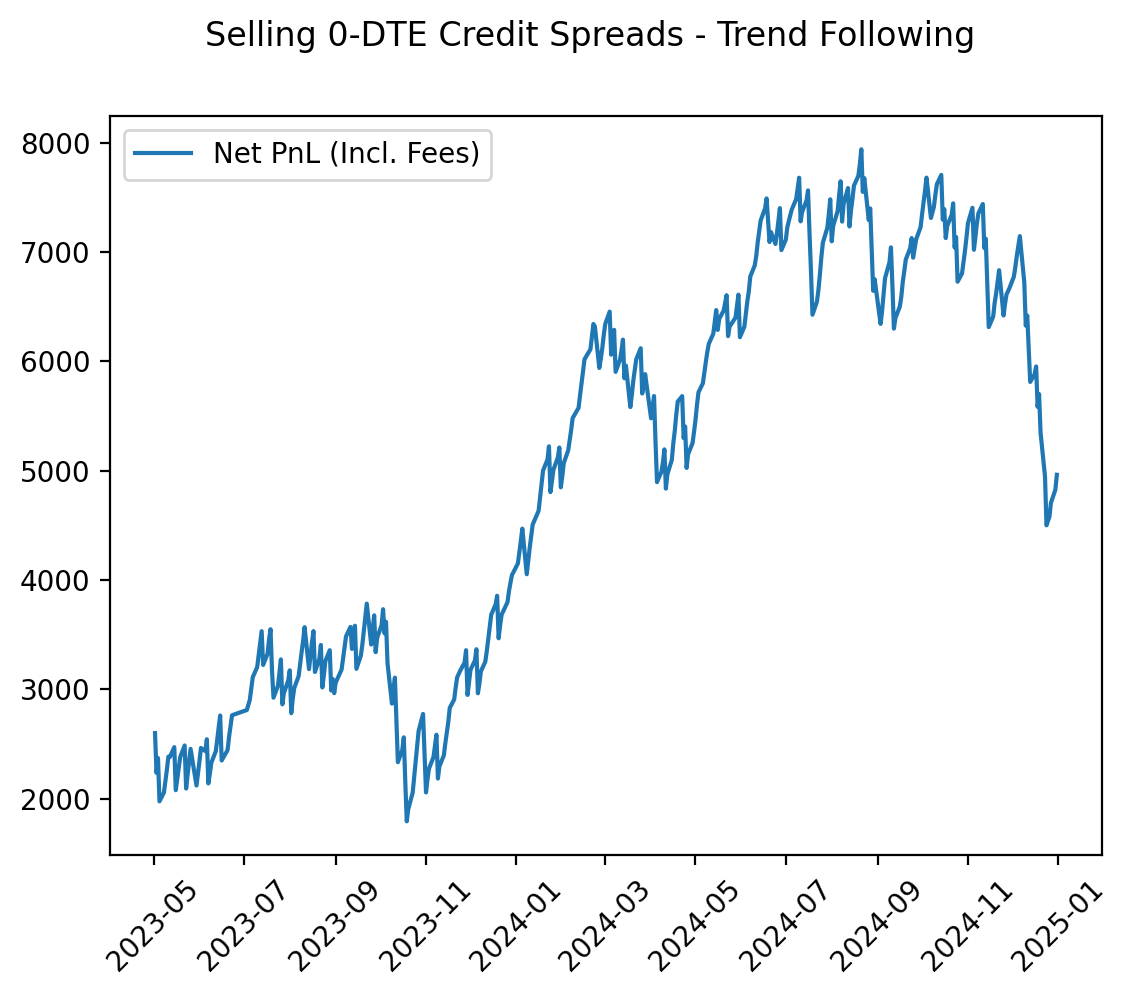

EV per trade: $6.0
Win Rate: 78.0%
Avg Profit: $107.94
Avg Loss: $-355.3
Total Profit: $1961.000000000054


C:\Users\Austin\AppData\Local\Temp\ipykernel_11196\1443823688.py:35: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = all_trades.resample("M").sum(numeric_only=True)


In [95]:
#############################################

vix_data = pd.json_normalize(requests.get(f"https://api.polygon.io/v2/aggs/ticker/I:VIX/range/1/day/2018-03-01/{trading_dates[-1]}?sort=asc&limit=50000&apiKey={polygon_api_key}").json()["results"]).set_index("t")
vix_data.index = pd.to_datetime(vix_data.index, unit="ms", utc=True).tz_convert("America/New_York")

vix_data["1_mo_avg"] = vix_data["c"].rolling(window=20).mean()
vix_data["3_mo_avg"] = vix_data["c"].rolling(window=60).mean()
vix_data['vol_regime'] = vix_data.apply(lambda row: 1 if (row['1_mo_avg'] > row['3_mo_avg']) else 0, axis=1).shift(1)
vix_data["str_date"] = vix_data.index.strftime("%Y-%m-%d")
vix_data = vix_data.set_index("str_date")

#############################################
    
all_trades = pd.concat(trade_list).drop_duplicates("date").set_index("date")
# all_trades = pd.concat([all_trades, vix_data[["3_mo_avg","vol_regime"]]], axis = 1).dropna()
# all_trades = all_trades[all_trades["vol_regime"] == 0].copy()
all_trades.index = pd.to_datetime(all_trades.index).tz_localize("America/New_York")

all_trades["contracts"] = 1
all_trades["fees"] = all_trades["contracts"] * 0.04
all_trades["net_pnl"] = (all_trades["gross_pnl"] * all_trades["contracts"]) - all_trades["fees"]

capital = 3000

all_trades["net_capital"] = capital + (all_trades["net_pnl"]*100).cumsum()

plt.figure(dpi=200)
plt.xticks(rotation=45)
plt.suptitle(f"Selling 0-DTE Credit Spreads - Trend Following")
plt.plot(all_trades.index, all_trades["net_capital"])
# plt.plot(np.arange(0, len(all_trades)), all_trades["net_capital"])
plt.legend(["Net PnL (Incl. Fees)"])
plt.show()

monthly = all_trades.resample("M").sum(numeric_only=True)

total_return = round(((all_trades["net_capital"].iloc[-1] - capital) / capital)*100, 2)
sd = round(all_trades["gross_pnl_percent"].std(), 2)

wins = all_trades[all_trades["net_pnl"] > 0]
losses = all_trades[all_trades["net_pnl"] < 0]

avg_win = wins["net_pnl"].mean()
avg_loss = losses["net_pnl"].mean()

win_rate = round(len(wins) / len(all_trades), 2)

expected_value = round((win_rate * avg_win) + ((1-win_rate) * avg_loss), 2)

print(f"EV per trade: ${expected_value*100}")
print(f"Win Rate: {win_rate*100}%")
print(f"Avg Profit: ${round(avg_win*100,2)}")
print(f"Avg Loss: ${round(avg_loss*100,2)}")
print(f"Total Profit: ${all_trades['net_pnl'].sum()*100}")